# Blip2 COCO Captions

In [1]:
import torch
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from datasets import COCODataset
from datasets import COCODataset
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BLIP-2 model and processor
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b")

# Ensure the model is on the correct device
model = model.to(device)

# Load COCO dataset
coco_dataset = COCODataset(ann_file='./data/coco/annotations/captions_val2017.json',
                           img_dir='./data/coco/val2017')

/home/gautom/anaconda3/envs/lavis/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [2]:
len(coco_dataset)

5000

## nbitlineardynamic.py

In [3]:
'''
nbitlinear.py
'''

from torch import nn, Tensor
import torch.nn.functional as F

def quant(x: Tensor, num_bits):
    min_val = x.min(dim=-1).values.unsqueeze(-1)
    max_val = x.max(dim=-1).values.unsqueeze(-1)
    
    alpha = max_val - min_val
    x = (x-min_val)/alpha
    
    scale = (2**num_bits - 1)
    result = (scale *x).round()
    result /= scale
    
    result = alpha * result + min_val
    
    return result
    

class NBitLinearDynamic(nn.Linear):
    def __init__(self,
                 *kargs,
                 weight_bits=8,
                 activation_bits=8,
                 **kwargs
    ):
        super().__init__(*kargs, **kwargs)
        self.weight_bits     = weight_bits
        self.activation_bits = activation_bits
        
    def forward(self, x: Tensor) -> Tensor:
        w = self.weight
        b = self.bias

        x_quant = x + (quant(x, self.activation_bits) - x).detach()
        w_quant = w + (quant(w, self.weight_bits) - w).detach()
        
        if b != None:
            b = b + (quant(b, self.weight_bits) - b).detach()
        
        y = F.linear(x_quant, w_quant, bias = b)
        
        return y
    
    def extra_repr(self) -> str:
        return super().extra_repr() + f' | w={self.weight_bits}, a={self.activation_bits}'



1-bit Quantization:
Min value: -2.6133224964141846
Max value: 3.4105026721954346
Unique values: 2

2-bit Quantization:
Min value: -2.6133224964141846
Max value: 3.4105026721954346
Unique values: 4

4-bit Quantization:
Min value: -2.6133224964141846
Max value: 3.4105026721954346
Unique values: 15

8-bit Quantization:
Min value: -2.6133224964141846
Max value: 3.4105026721954346
Unique values: 76


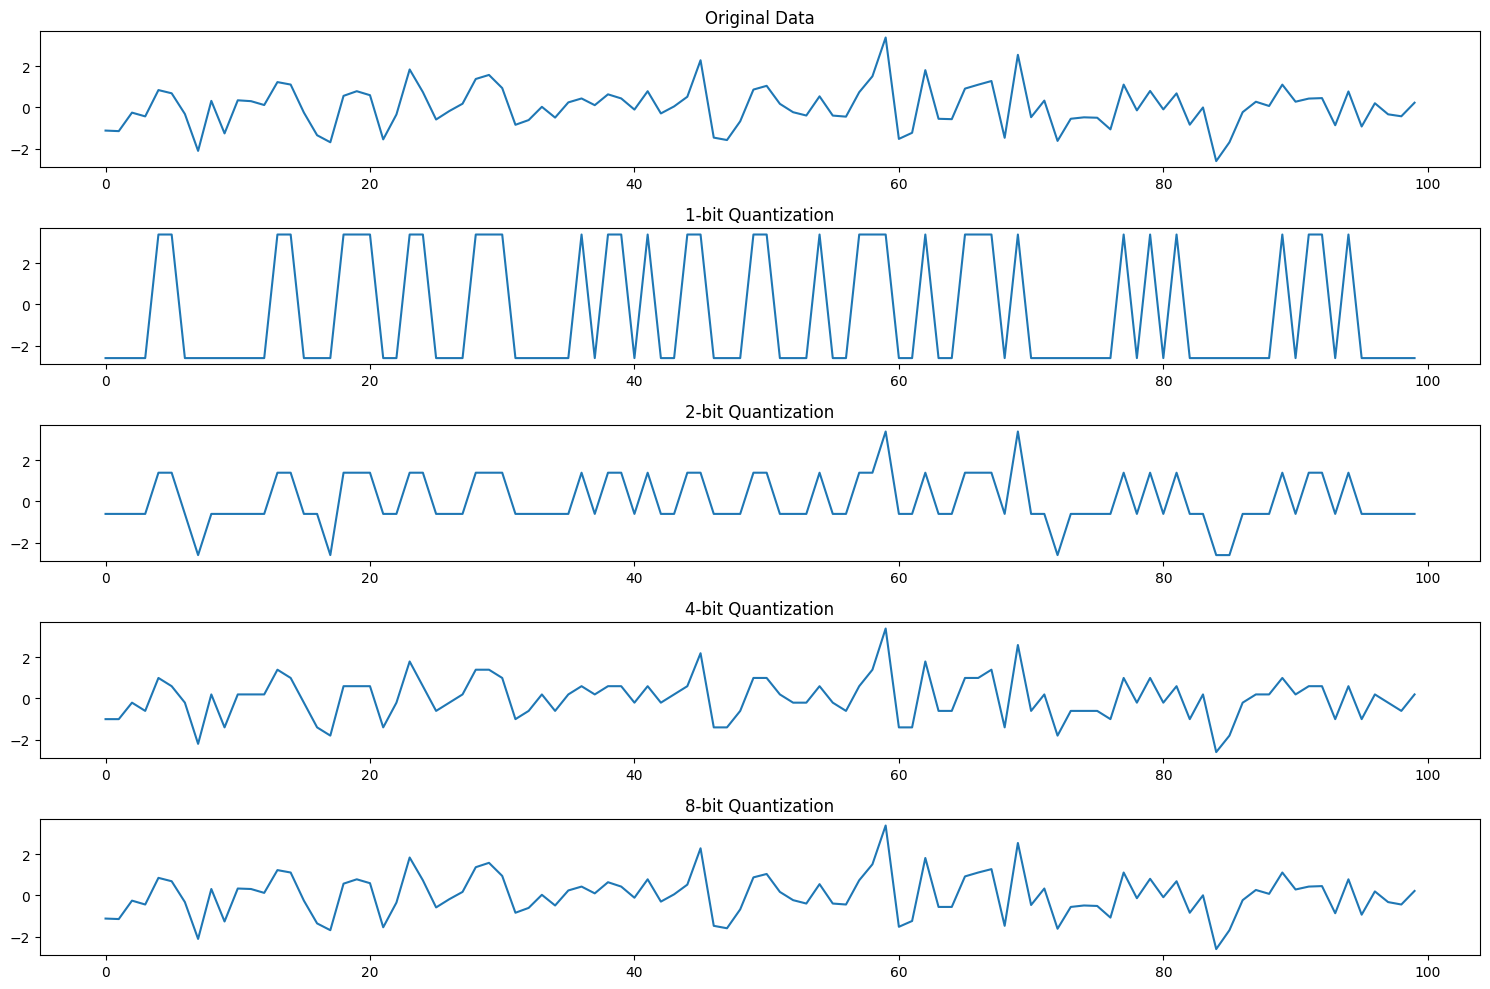

In [18]:
import torch
from torch import Tensor
import matplotlib.pyplot as plt

def quant(x: Tensor, num_bits):
    min_val = x.min(dim=-1).values.unsqueeze(-1)
    max_val = x.max(dim=-1).values.unsqueeze(-1)
    
    alpha = max_val - min_val
    x = (x-min_val)/alpha
    
    scale = (2**num_bits - 1)
    result = (scale *x).round()
    result /= scale
    
    result = alpha * result + min_val
    
    return result

def test_quantization():
    # Create a sample tensor
    torch.manual_seed(0)  # for reproducibility
    x = torch.randn(1, 100)  # 1x100 tensor of random values

    # Test different bit sizes
    bit_sizes = [1, 2, 4, 8]
    
    plt.figure(figsize=(15, 10))
    plt.subplot(len(bit_sizes) + 1, 1, 1)
    plt.plot(x.squeeze().numpy())
    plt.title("Original Data")
    
    for i, bits in enumerate(bit_sizes):
        quantized = quant(x, bits)
        
        plt.subplot(len(bit_sizes) + 1, 1, i + 2)
        plt.plot(quantized.squeeze().numpy())
        plt.title(f"{bits}-bit Quantization")
        
        print(f"\n{bits}-bit Quantization:")
        print("Min value:", quantized.min().item())
        print("Max value:", quantized.max().item())
        print("Unique values:", torch.unique(quantized).numel())
        
    plt.tight_layout()
    plt.show()

test_quantization()


1-bit Quantization:
Min value: -4.452163219451904
Max value: 4.11126184463501
Unique values: 2

2-bit Quantization:
Min value: -4.452163219451904
Max value: 4.11126184463501
Unique values: 4

4-bit Quantization:
Min value: -4.452163219451904
Max value: 4.11126184463501
Unique values: 16

8-bit Quantization:
Min value: -4.452163219451904
Max value: 4.11126184463501
Unique values: 230


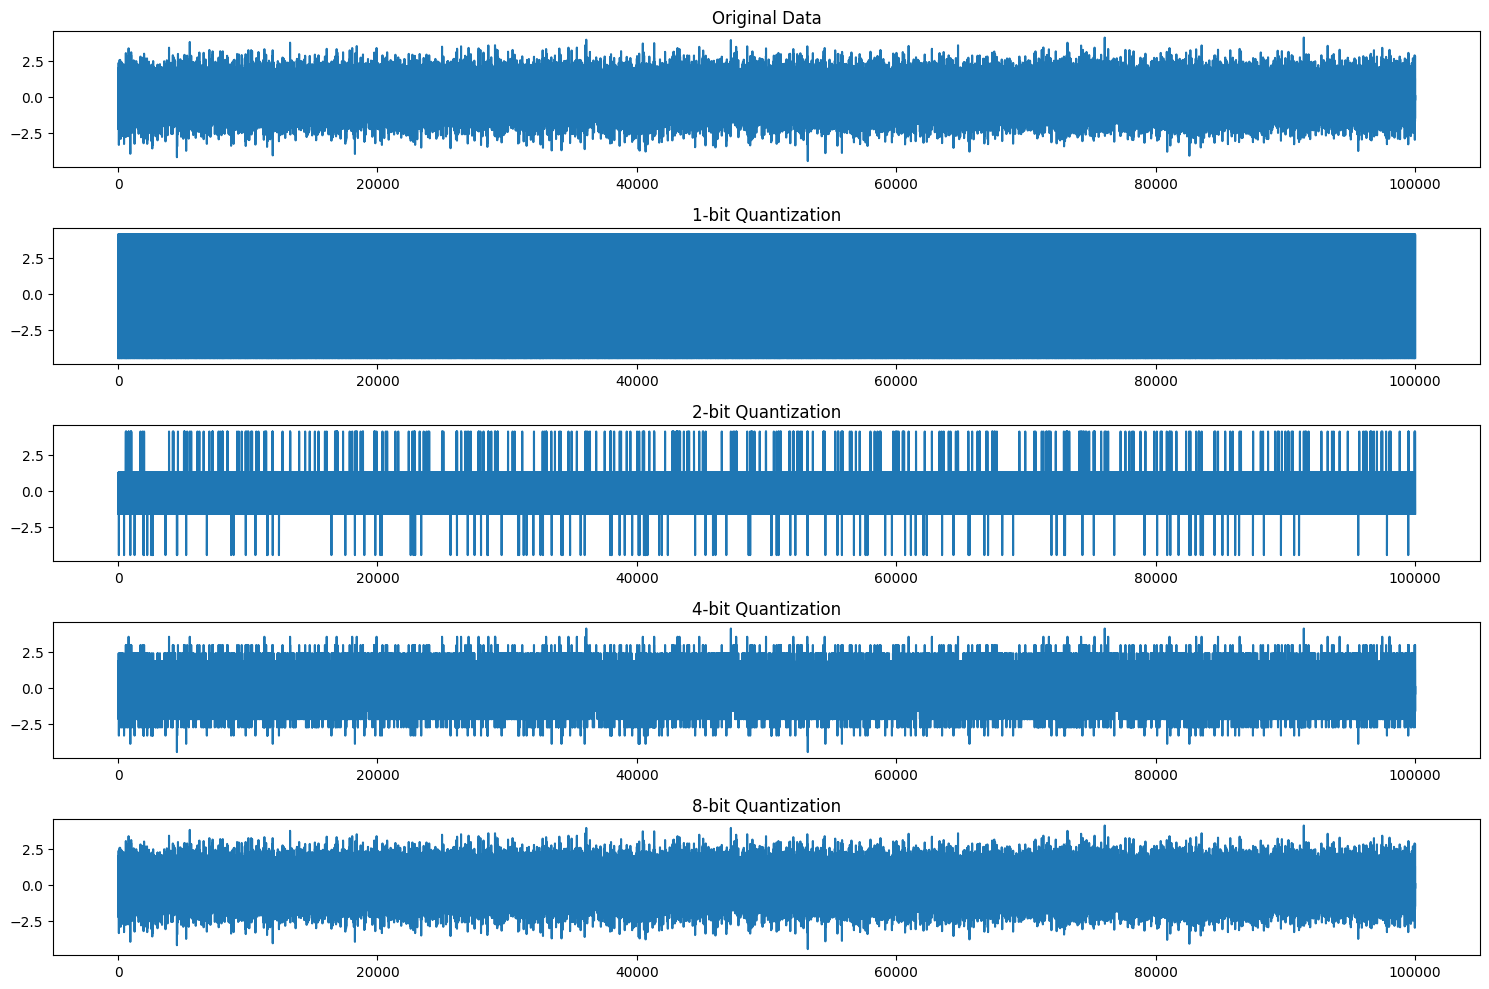

In [22]:
'''
nbitlinear.py
'''
import torch
from torch import nn, Tensor
import torch.nn.functional as F

def quant(x: Tensor, num_bits):
    min_val = x.min()
    max_val = x.max()
    
    alpha = max_val - min_val
    x = (x - min_val) / alpha
    
    scale = (2**num_bits - 1)
    result = (scale * x).round()
    result /= scale
    
    result = alpha * result + min_val
    
    return result

class NBitLinearDynamic(nn.Linear):
    def __init__(self,
                 *args,
                 weight_bits=8,
                 **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.weight_bits = weight_bits
        
        # Pre-compute quantized weights and biases
        self.register_buffer('weight_quant', quant(self.weight, self.weight_bits))
        if self.bias is not None:
            self.register_buffer('bias_quant', quant(self.bias, self.weight_bits))
        
    def forward(self, x: Tensor) -> Tensor:
        y = F.linear(x, self.weight_quant, bias=self.bias_quant if self.bias is not None else None)
        return y
    
    def extra_repr(self) -> str:
        return super().extra_repr() + f' | w={self.weight_bits}'

def replace_linear_with_quantized(model: nn.Module, weight_bits: int = 2) -> nn.Module:
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            quantized_linear = NBitLinearDynamic(
                in_features=module.in_features,
                out_features=module.out_features,
                bias=module.bias is not None,
                weight_bits=weight_bits
            )
            
            # Copy the weights and bias
            quantized_linear.weight.data = module.weight.data
            if module.bias is not None:
                quantized_linear.bias.data = module.bias.data
            
            # Replace the original linear layer with the quantized version
            setattr(model, name, quantized_linear)
        elif isinstance(module, nn.Module):
            # Recursively apply to child modules
            setattr(model, name, replace_linear_with_quantized(module, weight_bits))
    
    return model


def test_quantization():
    # Create a sample tensor
    torch.manual_seed(1)  # for reproducibility
    x = torch.randn(1, 100000)  # 1x100 tensor of random values

    # Test different bit sizes
    bit_sizes = [1, 2, 4, 8]
    
    plt.figure(figsize=(15, 10))
    plt.subplot(len(bit_sizes) + 1, 1, 1)
    plt.plot(x.squeeze().numpy())
    plt.title("Original Data")
    
    for i, bits in enumerate(bit_sizes):
        quantized = quant(x, bits)
        
        plt.subplot(len(bit_sizes) + 1, 1, i + 2)
        plt.plot(quantized.squeeze().numpy())
        plt.title(f"{bits}-bit Quantization")
        
        print(f"\n{bits}-bit Quantization:")
        print("Min value:", quantized.min().item())
        print("Max value:", quantized.max().item())
        print("Unique values:", torch.unique(quantized).numel())
        
    plt.tight_layout()
    plt.show()

test_quantization()

## quantize

In [4]:
import torch
import torch.nn as nn
from typing import Union, Tuple

def replace_linear_with_quantized(model: nn.Module, weight_bits: int = 8, activation_bits: int = 8) -> nn.Module:
    """
    Replaces nn.Linear layers in a PyTorch model with NBitLinearDynamic layers.
    
    Args:
        model (nn.Module): The PyTorch model to modify.
        weight_bits (int): Number of bits for weight quantization. Default is 8.
        activation_bits (int): Number of bits for activation quantization. Default is 8.
    
    Returns:
        nn.Module: The modified model with quantized linear layers.
    """
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            quantized_linear = NBitLinearDynamic(
                in_features=module.in_features,
                out_features=module.out_features,
                bias=module.bias is not None,
                weight_bits=weight_bits,
                activation_bits=activation_bits
            )
            
            # Copy the weights and bias
            quantized_linear.weight.data = module.weight.data
            if module.bias is not None:
                quantized_linear.bias.data = module.bias.data
            
            # Replace the original linear layer with the quantized version
            setattr(model, name, quantized_linear)
        elif isinstance(module, nn.Module):
            # Recursively apply to child modules
            setattr(model, name, replace_linear_with_quantized(module, weight_bits, activation_bits))
    
    return model

In [5]:
quantized_model = replace_linear_with_quantized(model, weight_bits=8, activation_bits=32)

## Collect Inference Results

In [3]:
import json

def eval_model(qmodel, results_file="./results/inference.json"):
    results = []

    for i in tqdm(range(0, min(50, len(coco_dataset)))):
        image, _ = coco_dataset[i]
        
        inputs = processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            out = qmodel.generate(**inputs)
        
        caption = processor.decode(out[0], skip_special_tokens=True).strip()
        
        image_id = coco_dataset.ids[i]
        results.append({"image_id": image_id, "caption": caption})

    with open(results_file, 'w') as f:
        json.dump(results, f)

In [10]:
eval_model(quantized_model)

100%|███████████████████████████████████████████| 50/50 [02:46<00:00,  3.33s/it]


In [4]:
eval_model(model, results_file="./results/inference_regular.json")

  0%|                                                    | 0/50 [00:00<?, ?it/s]/home/gautom/anaconda3/envs/lavis/lib/python3.8/site-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|███████████████████████████████████████████| 50/50 [00:14<00:00,  3.45it/s]


In [7]:
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.cider.cider import Cider

class SimpleCIDErEval:
    def __init__(self):
        self.tokenizer = PTBTokenizer()
        self.cider_scorer = Cider()

    def evaluate(self, predictions, references):
        # Format the input for the tokenizer
        gts = {i: [{'caption': c} for c in refs] for i, refs in enumerate(references)}
        res = {i: [{'caption': p}] for i, p in enumerate(predictions)}

        # Tokenize
        gts_tokenized = self.tokenizer.tokenize(gts)
        res_tokenized = self.tokenizer.tokenize(res)

        # Compute CIDEr score
        score, scores = self.cider_scorer.compute_score(gts_tokenized, res_tokenized)

        return score, scores

def score_results(results_file="./results/inference.json"):
    f = open(results_file)
    results = json.load(f)
    f.close()
    
    candidates = [result['caption'] for result in results]
    references = [coco_dataset.get_captions(result['image_id']) for result in results]
    
    # Create evaluator
    evaluator = SimpleCIDErEval()
    
    overall_score, individual_scores = evaluator.evaluate(candidates, references)
    
    print(f"Overall CIDEr score: {overall_score}")

In [10]:
score_results("./results/inference.json")

PTBTokenizer tokenized 3110 tokens at 34327.52 tokens per second.


Overall CIDEr score: 1.0523640496626538


PTBTokenizer tokenized 469 tokens at 5885.33 tokens per second.


## Save Results

In [8]:
import json
with open('./results/coco_results.json', 'w') as f:
    json.dump(results, f)

## Evaluate Results

In [9]:
# get pycocoevalfolder
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Add the current directory to the Python path
if current_dir not in sys.path:
    sys.path.append(current_dir)

# Verify the path
print(sys.path)

['/home/gautom/Documents/lavis', '/home/gautom/anaconda3/envs/lavis/lib/python38.zip', '/home/gautom/anaconda3/envs/lavis/lib/python3.8', '/home/gautom/anaconda3/envs/lavis/lib/python3.8/lib-dynload', '', '/home/gautom/.local/lib/python3.8/site-packages', '/home/gautom/anaconda3/envs/lavis/lib/python3.8/site-packages']


In [10]:
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.cider.cider import Cider

class SimpleCIDErEval:
    def __init__(self):
        self.tokenizer = PTBTokenizer()
        self.cider_scorer = Cider()

    def evaluate(self, predictions, references):
        # Format the input for the tokenizer
        gts = {i: [{'caption': c} for c in refs] for i, refs in enumerate(references)}
        res = {i: [{'caption': p}] for i, p in enumerate(predictions)}

        # Tokenize
        gts_tokenized = self.tokenizer.tokenize(gts)
        res_tokenized = self.tokenizer.tokenize(res)

        # Compute CIDEr score
        score, scores = self.cider_scorer.compute_score(gts_tokenized, res_tokenized)

        return score, scores

In [13]:
coco_dataset = COCODataset(ann_file='./data/coco/annotations/captions_val2017.json',
                           img_dir='./data/coco/val2017')

f = open('./results/coco_results.json')
results = json.load(f)
f.close()

candidates = [result['caption'] for result in results]
references = [coco_dataset.get_captions(result['image_id']) for result in results]

# Create evaluator
evaluator = SimpleCIDErEval()

overall_score, individual_scores = evaluator.evaluate(candidates, references)

print(f"Overall CIDEr score: {overall_score}")

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


PTBTokenizer tokenized 61766 tokens at 324387.99 tokens per second.
PTBTokenizer tokenized 9242 tokens at 88794.51 tokens per second.


Overall CIDEr score: 1.2852764152502318


In [15]:
from cidereval import cider
cider_scores = cider(candidates, references)

print(f"Average CIDEr score: {cider_scores['avg_score']}")

PTBTokenizer tokenized 61766 tokens at 336821.45 tokens per second.
PTBTokenizer tokenized 9242 tokens at 90941.95 tokens per second.


Average CIDEr score: 1.422928345185765


## Replace and test replacement for BLIP-2

In [9]:
import torch
import torch.nn as nn
from typing import Union, Tuple

def replace_linear_with_quantized(model: nn.Module, weight_bits: int = 8, activation_bits: int = 8) -> nn.Module:
    """
    Replaces nn.Linear layers in a PyTorch model with NBitLinearDynamic layers.
    
    Args:
        model (nn.Module): The PyTorch model to modify.
        weight_bits (int): Number of bits for weight quantization. Default is 8.
        activation_bits (int): Number of bits for activation quantization. Default is 8.
    
    Returns:
        nn.Module: The modified model with quantized linear layers.
    """
    for name, module in model.named_children():
        if isinstance(module, nn.Linear):
            quantized_linear = NBitLinearDynamic(
                in_features=module.in_features,
                out_features=module.out_features,
                bias=module.bias is not None,
                weight_bits=weight_bits,
                activation_bits=activation_bits
            )
            
            # Copy the weights and bias
            quantized_linear.weight.data = module.weight.data
            if module.bias is not None:
                quantized_linear.bias.data = module.bias.data
            
            # Replace the original linear layer with the quantized version
            setattr(model, name, quantized_linear)
        elif isinstance(module, nn.Module):
            # Recursively apply to child modules
            setattr(model, name, replace_linear_with_quantized(module, weight_bits, activation_bits))
    
    return model

In [10]:
# Assuming you have a PyTorch model called 'my_model'
quantized_model = replace_linear_with_quantized(model, weight_bits=16, activation_bits=32)

In [12]:
quantized_model

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): NBitLinearDynamic(in_features=1408, out_features=4224, bias=True | w=16, a=32)
            (projection): NBitLinearDynamic(in_features=1408, out_features=1408, bias=True | w=16, a=32)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): NBitLinearDynamic(in_features=1408, out_features=6144, bias=True | w=16, a=32)
            (fc2): NBitLinearDynamic(in_features=6144, out_features=1408, bias=True | w=16, a=32)
          )
          (layer_norm2): LayerNorm((1408,

### Taken from nbitlineardynamic.py:

In [7]:
'''
nbitlinear.py
'''

from torch import nn, Tensor
import torch.nn.functional as F

def quant(x: Tensor, num_bits):
    min_val = x.min(dim=-1).values.unsqueeze(-1)
    max_val = x.max(dim=-1).values.unsqueeze(-1)
    
    alpha = max_val - min_val
    x = (x-min_val)/alpha
    
    scale = (2**num_bits - 1)
    result = (scale *x).round()
    result /= scale
    
    result = alpha * result + min_val
    
    return result
    

class NBitLinearDynamic(nn.Linear):
    def __init__(self,
                 *kargs,
                 weight_bits=8,
                 activation_bits=8,
                 **kwargs
    ):
        super().__init__(*kargs, **kwargs)
        self.weight_bits     = weight_bits
        self.activation_bits = activation_bits
        
    def forward(self, x: Tensor) -> Tensor:
        w = self.weight
        b = self.bias

        x_quant = x + (quant(x, self.activation_bits) - x).detach()
        w_quant = w + (quant(w, self.weight_bits) - w).detach()
        
        if b != None:
            b = b + (quant(b, self.weight_bits) - b).detach()
        
        y = F.linear(x_quant, w_quant, bias = b)
        
        return y
    
    def extra_repr(self) -> str:
        return super().extra_repr() + f' | w={self.weight_bits}, a={self.activation_bits}'
